In [55]:
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
csv_path = 'data/parameter_sweep.csv'
df = pd.read_csv(csv_path)
df.head()

num_nan_snowball = df['snowball_num'].isna().sum()
print(f"{num_nan_snowball} NaN rows")
df = df.dropna(subset=['snowball_num'])

df.head()

3721 NaN rows


,Ti,To,ai,ao,V_C,V_red,W_sea,n,forg,nb,...,tau,W_LIP,n_LIP,PC_LIP,snowball_num,end_time,sb_dur_first,ig_dur_last,LIP_volume_end,t_max_used
0,241.203065,290.480342,0.722154,0.239575,7.752906,1.266756,1.193577,0.776621,0.299106,1.123155,...,41.818636,1.107798,0.425656,0.010849,0.0,100.00,NaN,NaN,1.848244e+15,52.599164
2,253.714185,285.510944,0.721863,0.302807,12.119870,0.946131,1.913946,0.214233,0.166857,1.586817,...,9.705320,42.791379,0.829561,0.008294,3.0,23.67,7.37,1.17,1.288609e+16,55.349345
3,263.643294,299.036790,0.673120,0.232340,6.415213,0.908834,2.266631,0.358222,0.303566,1.016443,...,78.644349,6.144880,0.718943,0.009730,6.0,NaN,17.78,3.14,2.316257e+16,100.000000
5,248.133339,286.757390,0.607630,0.336872,6.913977,1.063477,0.773107,0.068654,0.280145,1.371250,...,11.913645,32.330785,0.141470,0.007734,14.0,38.12,1.83,4.18,1.036391e+16,62.328430
6,257.961595,299.153869,0.680847,0.252156,10.177091,0.549575,0.227936,0.554603,0.145727,1.732628,...,54.271430,11.394438,0.401554,0.009086,15.0,NaN,5.62,1.66,1.771331e+16,100.000000


In [57]:
import numpy as np

# Masks for capped and uncapped
capped_mask = (df['end_time'].isna() | np.isclose(df['end_time'].iloc[-1],df['t_max_used']))
uncapped_mask = ~capped_mask

# Define class masks
no_snowball_mask = df['snowball_num'] == 0
one_snowball_mask = df['snowball_num'] == 1
limit_cycle_mask = df['snowball_num'] > 1

# Totals per class
total_no = no_snowball_mask.sum()
total_one = one_snowball_mask.sum()
total_cycle = limit_cycle_mask.sum()

# Capped counts per class
capped_no = (capped_mask & no_snowball_mask).sum()
capped_one = (capped_mask & one_snowball_mask).sum()
capped_cycle = (capped_mask & limit_cycle_mask).sum()

# Uncapped counts per class
uncapped_no = total_no - capped_no
uncapped_one = total_one - capped_one
uncapped_cycle = total_cycle - capped_cycle

# Create subsets per class
df_no_snowball = df.loc[no_snowball_mask]
df_one_snowball = df.loc[one_snowball_mask]
df_limit_cycle = df.loc[limit_cycle_mask]
df_any_snowball = df.loc[~no_snowball_mask]

# Create uncapped subsets
df_no_snowball_uncapped = df.loc[no_snowball_mask & uncapped_mask]
df_one_snowball_uncapped = df.loc[one_snowball_mask & uncapped_mask]
df_limit_cycle_uncapped = df.loc[limit_cycle_mask & uncapped_mask]


# Summary lines
print(f"{total_no} no snowball = {uncapped_no} uncapped + {capped_no} capped")
print(f"{total_one} 1 snowball = {uncapped_one} uncapped + {capped_one} capped")
print(f"{total_cycle} limit cycles = {uncapped_cycle} uncapped + {capped_cycle} capped")

total_num = total_no + total_one + total_cycle
print(f"\nOut of total:")
print(f"    {(total_no/total_num*100):0.1f}% no snowball")
print(f"    {(total_one/total_num*100):0.1f}% 1 snowball")
print(f"    {(total_cycle/total_num*100):0.1f}% limit cycle")

total_snow = total_one + total_cycle
print(f"Of runs achieving Snowball:")
print(f"    {(total_one/total_snow*100):0.1f}% 1 snowball")
print(f"    {(total_cycle/total_snow*100):0.1f}% limit cycle")


1630 no snowball = 1630 uncapped + 0 capped
630 1 snowball = 630 uncapped + 0 capped
4019 limit cycles = 3030 uncapped + 989 capped

Out of total:
    26.0% no snowball
    10.0% 1 snowball
    64.0% limit cycle
Of runs achieving Snowball:
    13.6% 1 snowball
    86.4% limit cycle


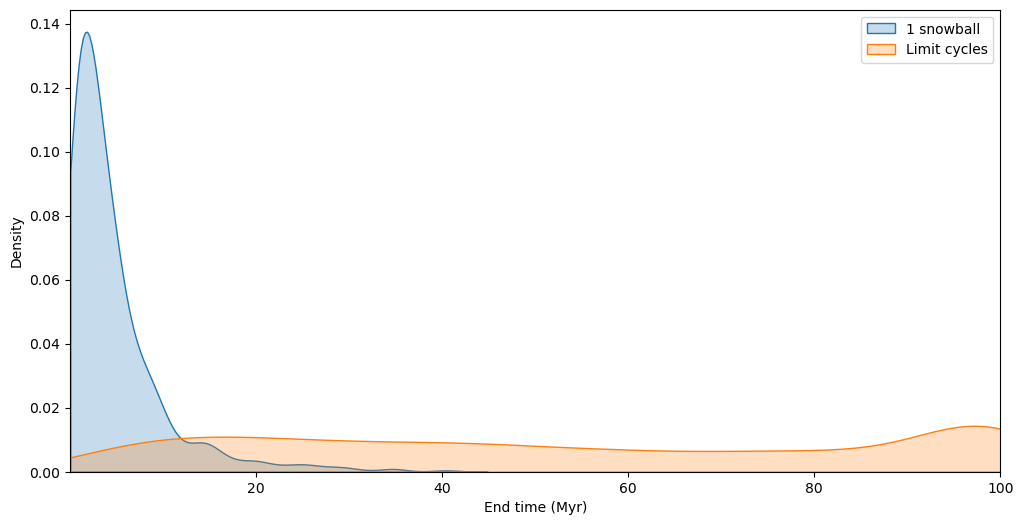

In [59]:
import seaborn as sns

# Determine actual bounds from the data
x_min = df['end_time'].min()
x_max = df['end_time'].max()

# Clip data to within [x_min, x_max]
end_one = df_one_snowball_uncapped['end_time'].clip(lower=x_min, upper=x_max)
end_cycle = df_limit_cycle_uncapped['end_time'].clip(lower=x_min, upper=x_max)

plt.figure(figsize=(12, 6))
sns.kdeplot(end_one, fill=True, label='1 snowball', clip=(x_min, x_max))
sns.kdeplot(end_cycle, fill=True, label='Limit cycles', clip=(x_min, x_max))
plt.xlim(x_min, x_max)
plt.xlabel('End time (Myr)')
plt.legend()
plt.show()

In [60]:
def param_density_plot(param_name, include_no_snowball=False,
                       ax=None, labels_on=False, x_label=None,
                      verbose=False):   

    if not x_label:
        x_label=param_name 
            
    if verbose:
        print(f"Means of {param_name}:")
        if include_no_snowball:
            print(f"    No snowball: {np.mean(df_no_snowball[param_name]):.4f}")
        print(f"    1 snowball: {np.mean(df_one_snowball[param_name]):.4f}")
        print(f"    Limit cycle: {np.mean(df_limit_cycle[param_name]):.4f}")
    
    
    ax_given = ax
    if not ax:
        fig,ax = plt.subplots(figsize=(4,2.5))
        labels_on = True
        
    labels = ['No Snowball','1 Snowball','Limit cycle']

    if include_no_snowball:
        sns.kdeplot(df_no_snowball[param_name], ax=ax, fill=True, color='burlywood', label=labels[0])
    sns.kdeplot(df_one_snowball[param_name], ax=ax, fill=True, color='turquoise', label=labels[1])
    sns.kdeplot(df_limit_cycle[param_name], ax=ax, fill=True, color='mediumorchid', label=labels[2])

    #ax.set_yticks([])
    ax.set_xlabel(x_label)
    ax.set_ylabel('Probability Density')
    if not ax_given:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.2), ncol=3)
    return ax

In [61]:
row_perturbation = ['W_LIP','tau','PC_LIP']
row_albedo = ['Ti','To','ai','ao']
row_carbon = ['V_C','W_sea','n','n_LIP']
row_oxygen = ['V_red','forg','nb']
row_phosphorus = ['P_conc','W_pho0']
rows = [row_perturbation, row_albedo, row_carbon, row_oxygen, row_phosphorus]


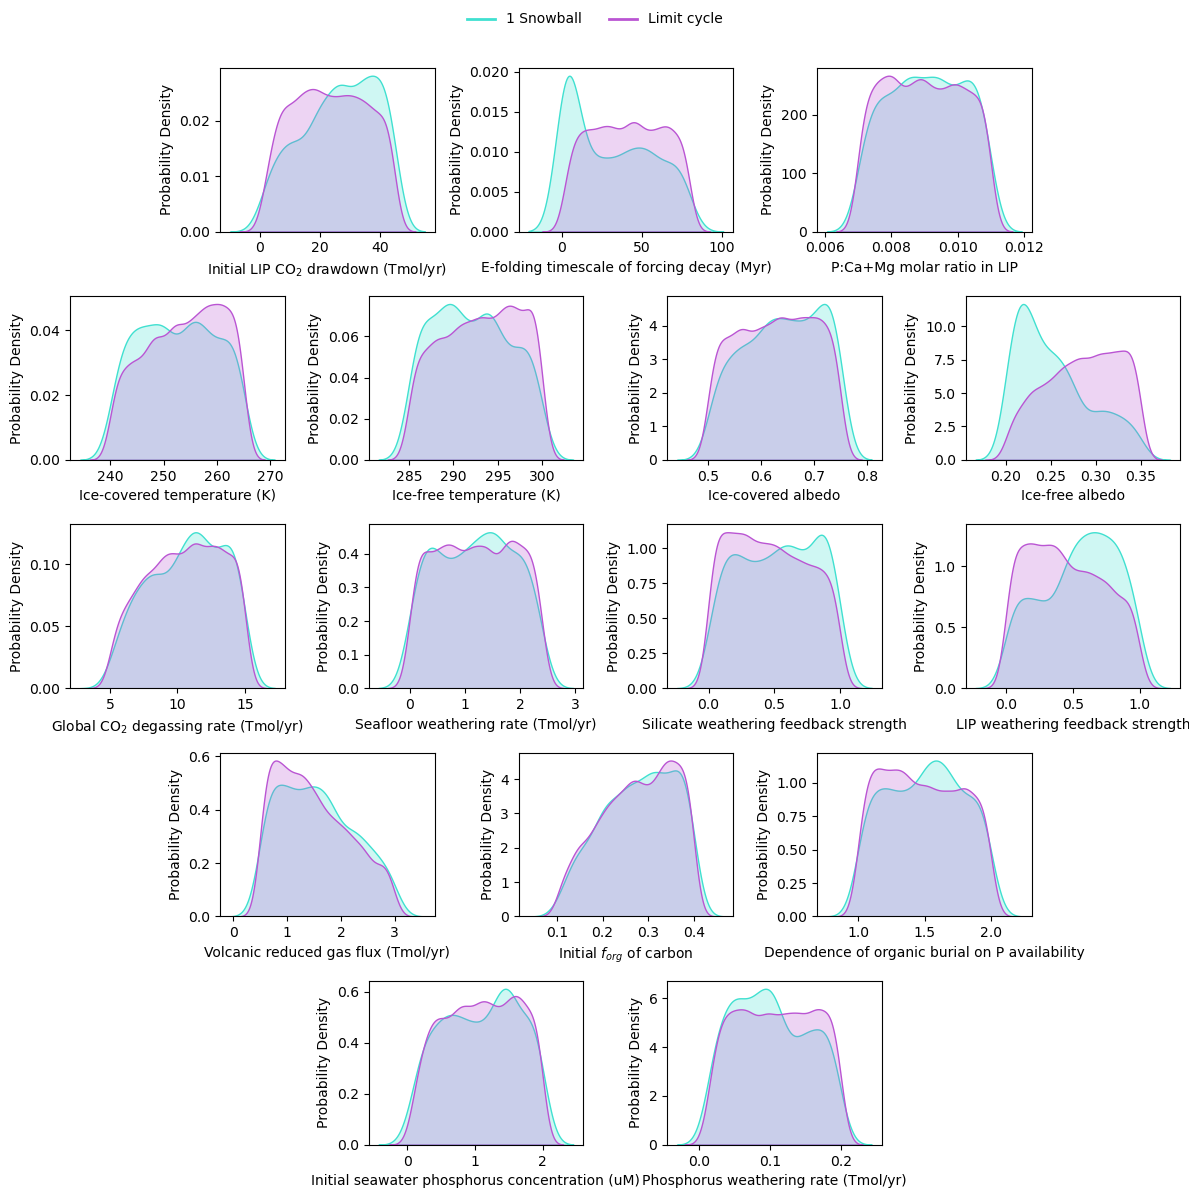

In [69]:
from matplotlib.lines import Line2D

# expanded axis labels
labels = {
    'W_LIP': 'Initial LIP CO$_2$ drawdown (Tmol/yr)',
    'tau': 'E-folding timescale of forcing decay (Myr)',
    'PC_LIP': 'P:Ca+Mg molar ratio in LIP',
    'n_LIP': 'LIP weathering feedback strength',
    'Ti': 'Ice-covered temperature (K)',
    'To': 'Ice-free temperature (K)',
    'ai': 'Ice-covered albedo',
    'ao': 'Ice-free albedo',
    'V_C': 'Global CO$_2$ degassing rate (Tmol/yr)',
    'W_sea': 'Seafloor weathering rate (Tmol/yr)',
    'n': 'Silicate weathering feedback strength',
    'V_red': 'Volcanic reduced gas flux (Tmol/yr)',
    'forg': 'Initial $f_{org}$ of carbon',
    'nb': 'Dependence of organic burial on P availability',
    'P_conc':'Initial seawater phosphorus concentration (uM)',
    'W_pho0':'Phosphorus weathering rate (Tmol/yr)'
}

n_rows = len(rows)
n_cols = max(len(r) for r in rows) if n_rows else 0
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12), squeeze=False)

# hide axes
for ax in axes.ravel():
    ax.set_axis_off()

# keep track of axes used per row
row_axes = [[] for _ in range(n_rows)]

for i, row in enumerate(rows):
    k = len(row)
    if k == 0:
        continue
    # center the row by offsetting the starting column
    offset = (n_cols - k) // 2
    for j, pname in enumerate(row):
        ax = axes[i, offset + j]
        ax.set_axis_on()
        row_axes[i].append(ax)
        if pname in df.columns:
            xlabel = labels.get(pname, pname)
            param_density_plot(pname, ax=ax, labels_on=False, x_label=xlabel)
        else:
            ax.text(0.5, 0.5, f"{pname} not in df", ha='center', va='center', fontsize=9)

# single legend
handles = [
    #Line2D([0], [0], color='burlywood', lw=2, label='No Snowball'),
    Line2D([0], [0], color='turquoise', lw=2, label='1 Snowball'),
    Line2D([0], [0], color='mediumorchid', lw=2, label='Limit cycle'),
]
fig.legend(handles=handles, loc='upper center', ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# nudge odd-length rows by half a column width
for i, row in enumerate(rows):
    k = len(row)
    if k == 0:
        continue
    d = n_cols - k
    if d % 2 == 1:
        dx = 0.5 / n_cols
        for ax in row_axes[i]:
            pos = ax.get_position()
            ax.set_position([pos.x0 + dx, pos.y0, pos.width, pos.height])

fig.savefig('figs/supp/density_plots.pdf',format='pdf',bbox_inches='tight',dpi=600)
plt.show()